# Spam Detection with Random Forest: Full Workflow, Hyperparameter Tuning, and Evaluation

This notebook demonstrates:
- Training a Random Forest classifier on `spam.csv`
- Data cleaning, EDA, and visualization
- Hyperparameter tuning and comparison
- Exporting the model/vectorizer for deployment
- Evaluation on `emails.csv` with all metrics and visualizations

# Random Forest Training and Evaluation

This notebook trains and evaluates a Random Forest classifier for spam detection, including data preprocessing, model training, and performance visualization.

In [ ]:
# Import libraries for data loading, preprocessing, model training, and evaluation
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# This cell sets up the libraries needed for training and evaluating a Random Forest classifier.

## 1. Data Loading and Initial EDA
Load `spam.csv`, inspect, and visualize class balance.

target
ham     4516
spam     653
Name: count, dtype: int64


[nltk_data] Downloading package punkt to C:\Users\nikhi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nikhi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


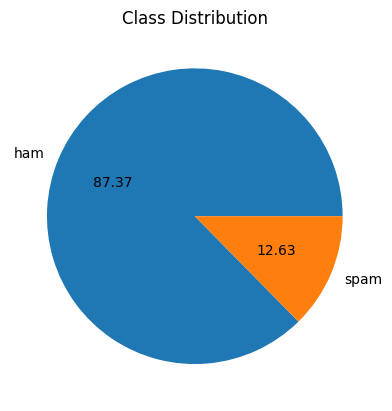

<class 'pandas.core.frame.DataFrame'>
Index: 5169 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   target  5169 non-null   object
 1   text    5169 non-null   object
dtypes: object(2)
memory usage: 121.1+ KB


,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [2]:
nltk.download('punkt')
nltk.download('stopwords')
df = pd.read_csv('spam.csv', encoding='latin1', on_bad_lines='skip')
df = df.drop(columns=['Unnamed: 2','Unnamed: 3', 'Unnamed: 4'], errors='ignore')
df = df.rename(columns={'v1': 'target', 'v2': 'text'})
df = df.drop_duplicates(keep='first').dropna()
print(df['target'].value_counts())
plt.pie(df['target'].value_counts(), labels=['ham', 'spam'], autopct='%0.2f')
plt.title('Class Distribution')
plt.show()
df.info()
df.head()

## 2. Data Preprocessing
Encode labels, clean text, and add feature columns for EDA.

In [3]:
encoder = LabelEncoder()
df['target'] = encoder.fit_transform(df['target'])
stemmer = PorterStemmer()
def transform_text(text):
    text = text.lower()
    text = nltk.word_tokenize(text)
    y = []
    for i in text:
        if i.isalnum():
            y.append(i)
    text = y[:]
    y.clear()
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)
    text = y[:]
    y.clear()
    for i in text:
        y.append(stemmer.stem(i))
    return " ".join(y)
df['transformed_text'] = df['text'].apply(transform_text)
df['num_characters'] = df['text'].apply(len)
df['num_words'] = df['text'].apply(lambda x: len(nltk.word_tokenize(x)))
df['num_sentences'] = df['text'].apply(lambda x: len(nltk.sent_tokenize(x)))
df[['num_characters', 'num_words', 'num_sentences']].describe()

,num_characters,num_words,num_sentences
count,5169.000000,5169.000000,5169.000000
mean,78.977945,18.455794,1.965564
std,58.236293,13.324758,1.448541
min,2.000000,1.000000,1.000000
25%,36.000000,9.000000,1.000000
50%,60.000000,15.000000,1.000000
75%,117.000000,26.000000,2.000000
max,910.000000,220.000000,38.000000


## 3. Exploratory Data Analysis (EDA)
Visualize feature distributions and correlations.

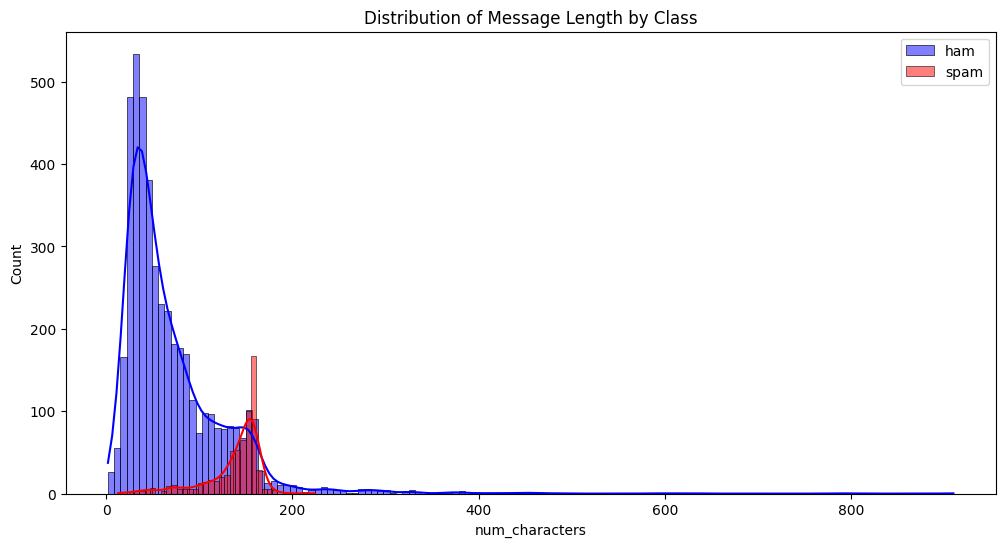

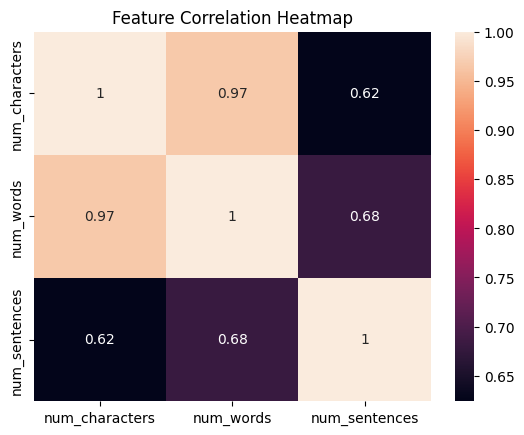

In [4]:
plt.figure(figsize=(12, 6))
sns.histplot(df[df['target']==0]['num_characters'], color='blue', label='ham', kde=True)
sns.histplot(df[df['target']==1]['num_characters'], color='red', label='spam', kde=True)
plt.legend()
plt.title('Distribution of Message Length by Class')
plt.show()
sns.heatmap(df[['num_characters', 'num_words', 'num_sentences']].corr(), annot=True)
plt.title('Feature Correlation Heatmap')
plt.show()

## 4. Most Common Words in Spam and Ham

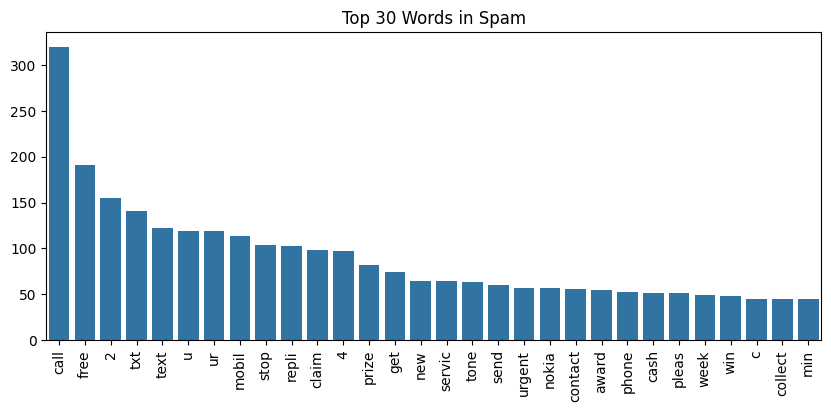

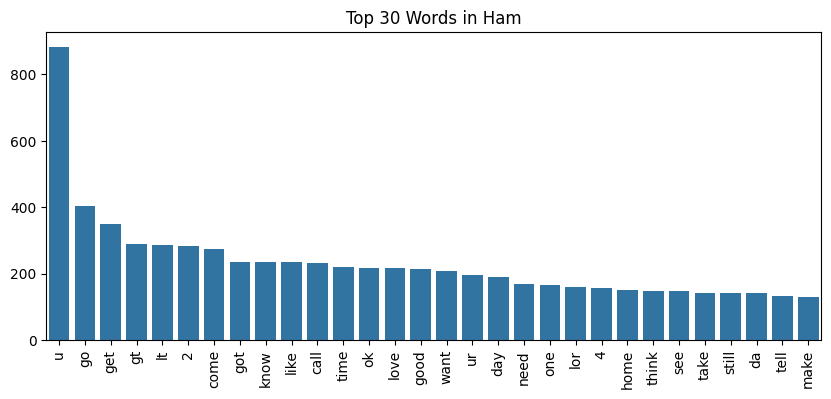

In [5]:
spam_corpus = []
for message in df[df['target']==1]['transformed_text'].to_list():
    for word in message.split():
        spam_corpus.append(word)
ham_corpus = []
for message in df[df['target']==0]['transformed_text'].to_list():
    for word in message.split():
        ham_corpus.append(word)
common_spam = Counter(spam_corpus).most_common(30)
common_ham = Counter(ham_corpus).most_common(30)
plt.figure(figsize=(10,4))
sns.barplot(x=[w[0] for w in common_spam], y=[w[1] for w in common_spam])
plt.xticks(rotation='vertical')
plt.title('Top 30 Words in Spam')
plt.show()
plt.figure(figsize=(10,4))
sns.barplot(x=[w[0] for w in common_ham], y=[w[1] for w in common_ham])
plt.xticks(rotation='vertical')
plt.title('Top 30 Words in Ham')
plt.show()

## 5. Feature Extraction: TF-IDF Vectorization

In [6]:
vectorizer = TfidfVectorizer(max_features=2000, min_df=2, max_df=0.9, ngram_range=(1,2))
X = vectorizer.fit_transform(df['transformed_text']).toarray()
y = df['target'].values

## 6. Train/Test Split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 7. Baseline Random Forest Training and Evaluation

Baseline Accuracy: 0.9729
Baseline Precision: 0.9756
Confusion Matrix:
 [[886   3]
 [ 25 120]]


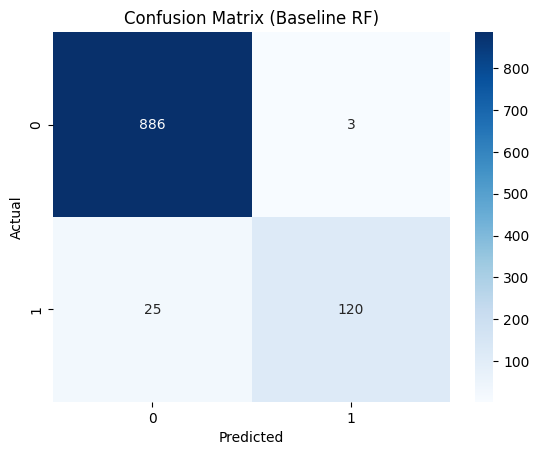

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       889
           1       0.98      0.83      0.90       145

    accuracy                           0.97      1034
   macro avg       0.97      0.91      0.94      1034
weighted avg       0.97      0.97      0.97      1034



In [8]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
print(f"Baseline Accuracy: {acc:.4f}")
print(f"Baseline Precision: {prec:.4f}")
print("Confusion Matrix:\n", cm)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Baseline RF)')
plt.show()
print(classification_report(y_test, y_pred))

## 8. Hyperparameter Tuning with GridSearchCV

In [9]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)
print('Best parameters:', grid.best_params_)
print('Best cross-validated accuracy:', grid.best_score_)
rf_best = grid.best_estimator_

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best cross-validated accuracy: 0.9748497838719081


## 9. Tuned Model Evaluation

Tuned RF Accuracy: 0.9778
Tuned RF Precision: 0.9841
Confusion Matrix:
 [[887   2]
 [ 21 124]]


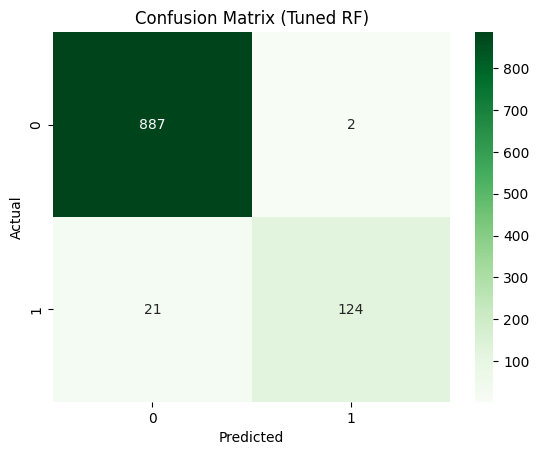

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       889
           1       0.98      0.86      0.92       145

    accuracy                           0.98      1034
   macro avg       0.98      0.93      0.95      1034
weighted avg       0.98      0.98      0.98      1034



In [10]:
y_pred_best = rf_best.predict(X_test)
acc_best = accuracy_score(y_test, y_pred_best)
prec_best = precision_score(y_test, y_pred_best)
cm_best = confusion_matrix(y_test, y_pred_best)
print(f"Tuned RF Accuracy: {acc_best:.4f}")
print(f"Tuned RF Precision: {prec_best:.4f}")
print("Confusion Matrix:\n", cm_best)
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Tuned RF)')
plt.show()
print(classification_report(y_test, y_pred_best))

## 10. Compare Baseline vs Tuned Model

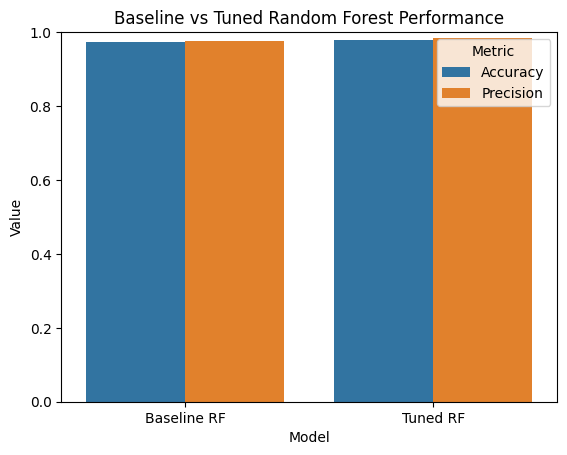

In [11]:
compare_df = pd.DataFrame({
    'Model': ['Baseline RF', 'Tuned RF'],
    'Accuracy': [acc, acc_best],
    'Precision': [prec, prec_best]
})
compare_df = compare_df.melt(id_vars='Model', var_name='Metric', value_name='Value')
sns.barplot(x='Model', y='Value', hue='Metric', data=compare_df)
plt.ylim(0, 1)
plt.title('Baseline vs Tuned Random Forest Performance')
plt.show()

## 11. Export Tuned Model and Vectorizer

In [12]:
with open('model.pkl', 'wb') as f:
    pickle.dump(rf_best, f)
with open('vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)
with open('transform_text.pkl', 'wb') as f:
    pickle.dump(transform_text, f)

## 12. Evaluate on New Data (emails.csv)

Test on emails.csv - Accuracy: 0.7659
Test on emails.csv - Precision: 0.5300


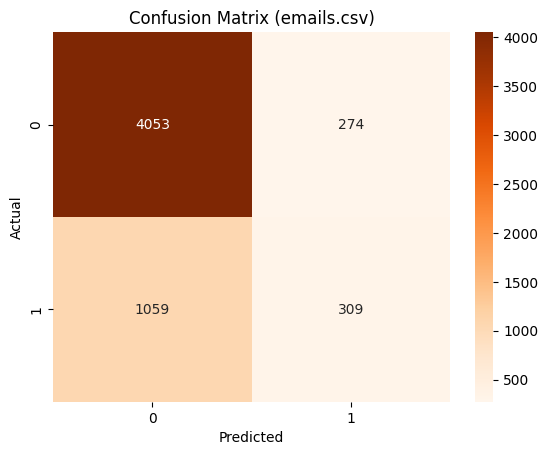

              precision    recall  f1-score   support

           0       0.79      0.94      0.86      4327
           1       0.53      0.23      0.32      1368

    accuracy                           0.77      5695
   macro avg       0.66      0.58      0.59      5695
weighted avg       0.73      0.77      0.73      5695



In [16]:
df_new = pd.read_csv('emails.csv')
df_new = df_new.rename(columns={'text': 'text', 'spam': 'target'})
df_new = df_new.dropna().drop_duplicates(keep='first')
df_new['target'] = df_new['target'].astype(int)
df_new['transformed_text'] = df_new['text'].apply(transform_text)
X_new = vectorizer.transform(df_new['transformed_text']).toarray()
y_new = df_new['target'].values
y_pred_new = rf_best.predict(X_new)
acc_new = accuracy_score(y_new, y_pred_new)
prec_new = precision_score(y_new, y_pred_new)
cm_new = confusion_matrix(y_new, y_pred_new)
print(f"Test on emails.csv - Accuracy: {acc_new:.4f}")
print(f"Test on emails.csv - Precision: {prec_new:.4f}")
sns.heatmap(cm_new, annot=True, fmt='d', cmap='Oranges')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (emails.csv)')
plt.show()
print(classification_report(y_new, y_pred_new))

## 13. Compare All Results

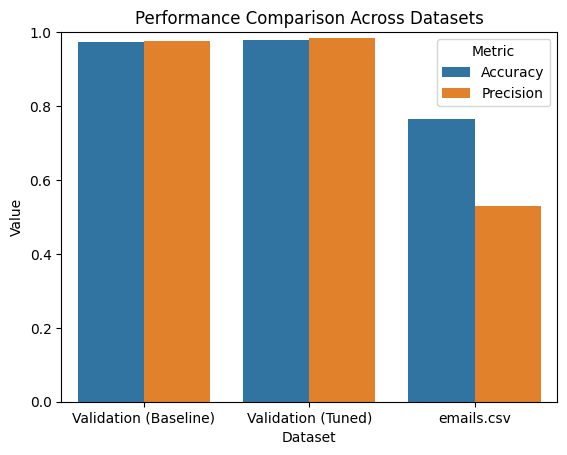

In [17]:
summary_df = pd.DataFrame({
    'Dataset': ['Validation (Baseline)', 'Validation (Tuned)', 'emails.csv'],
    'Accuracy': [acc, acc_best, acc_new],
    'Precision': [prec, prec_best, prec_new]
})
summary_df = summary_df.melt(id_vars='Dataset', var_name='Metric', value_name='Value')
sns.barplot(x='Dataset', y='Value', hue='Metric', data=summary_df)
plt.ylim(0, 1)
plt.title('Performance Comparison Across Datasets')
plt.show()

# Summary
- Trained and tuned a Random Forest classifier for spam detection
- Visualized data, features, and model performance
- Exported model/vectorizer for deployment
- Evaluated on new data and compared all results


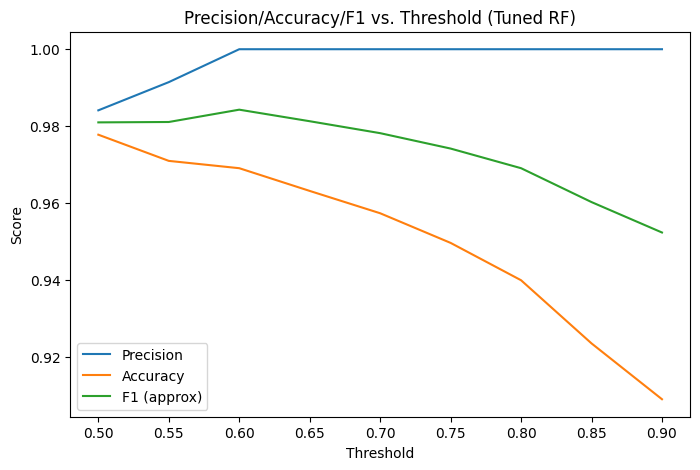

High Precision Threshold=0.7: Accuracy=0.9574, Precision=1.0000


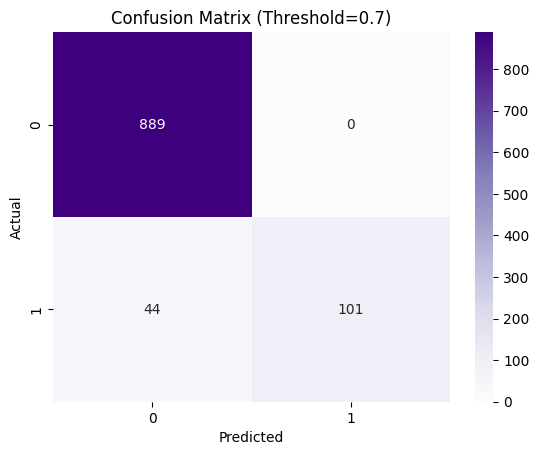

              precision    recall  f1-score   support

           0       0.95      1.00      0.98       889
           1       1.00      0.70      0.82       145

    accuracy                           0.96      1034
   macro avg       0.98      0.85      0.90      1034
weighted avg       0.96      0.96      0.95      1034



In [18]:
# Predict probabilities for the positive class (spam)
y_proba_best = rf_best.predict_proba(X_test)[:, 1]

# Try different thresholds to maximize precision
from sklearn.metrics import precision_recall_curve
thresholds = np.arange(0.5, 0.95, 0.05)
precisions = []
recalls = []
f1s = []
for thresh in thresholds:
    y_pred_thresh = (y_proba_best >= thresh).astype(int)
    precisions.append(precision_score(y_test, y_pred_thresh))
    recalls.append(np.round(np.mean(y_test == y_pred_thresh), 4))
    f1s.append(np.round(2 * (precisions[-1] * recalls[-1]) / (precisions[-1] + recalls[-1] + 1e-8), 4))

plt.figure(figsize=(8,5))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Accuracy')
plt.plot(thresholds, f1s, label='F1 (approx)')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision/Accuracy/F1 vs. Threshold (Tuned RF)')
plt.legend()
plt.show()

# Pick a higher threshold for higher precision (e.g., 0.7)
chosen_thresh = 0.7
y_pred_high_prec = (y_proba_best >= chosen_thresh).astype(int)
acc_high_prec = accuracy_score(y_test, y_pred_high_prec)
prec_high_prec = precision_score(y_test, y_pred_high_prec)
cm_high_prec = confusion_matrix(y_test, y_pred_high_prec)
print(f"High Precision Threshold={chosen_thresh}: Accuracy={acc_high_prec:.4f}, Precision={prec_high_prec:.4f}")
sns.heatmap(cm_high_prec, annot=True, fmt='d', cmap='Purples')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix (Threshold={chosen_thresh})')
plt.show()
print(classification_report(y_test, y_pred_high_prec))